In [1]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [48]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py2-env/20160822/envs/agdc/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [49]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [50]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [51]:
#dc.list_measurements()

In [52]:
def geom_query(geom, geom_crs='EPSG:28355'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [53]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range


vec_fname = '/g/data/r78/lxl554/hovmoller/Clean map.shp' #comment these lines out if running without polygon
src = fiona.open(vec_fname)
geom = shape(src[0]['geometry'])




#Define temporal range
start_of_epoch = '2000-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-07-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     #'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'

query = {
    'time': (start_of_epoch, end_of_epoch),
}

#query.update(geom_query(geom)) #comment this out if not using a polygon

#If not using a polygon/polyline, enter lat/lon here manually
lat_max = -13.7
lat_min = -13.8
lon_max = 131.9
lon_min = 131.56
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [54]:
print query

{'y': (-13.7, -13.8), 'x': (131.56, 131.9), 'crs': 'EPSG:4326', 'time': ('2000-01-01', '2016-07-31')}


## Retrieve surface reflectance data


In [55]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [56]:
#load sensor specific band adjustment tuples for TSS and brightness

In [57]:
#load sensor specific band adjustment tuples for TSS 
ls5_tss_constant = 3983
ls5_tss_exponent = 1.6246
ls7_tss_constant = 3983
ls7_tss_exponent = 1.6246
ls8_tss_constant = 3957
ls8_tss_exponent = 1.6436

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [58]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [59]:
crs = sensor1_nbar.crs.wkt
affine = sensor1_nbar.affine

In [61]:
affine

Affine(25.0, 0.0, -48250.0,
       0.0, -25.0, -1449300.0)

In [14]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [15]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, ga_good_pixel= True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [16]:
#Fix the TSS coefficients for each sensor
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR','NDWI','TSS']
sensor1_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor1_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor1_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor1_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    #sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))
    #sensor1_rsindex['NDWI'] = ((sensor1_nbar['swir1']-sensor1_nbar['green'])/(sensor1_nbar['swir1']+sensor1_nbar['green']))
    sensor1_rsindex['NBR'] = ((sensor1_nbar['nir']-sensor1_nbar['swir2'])/(sensor1_nbar['nir']+sensor1_nbar['swir2']))
    #Need this to reference into a tuple - Check with Damien    
    #sensor1_rsindex['TSS'] = (ls8_tss_constant*((sensor1_nbar['green']+sensor1_nbar['red'])/20000)**ls8_tss_exponent)

In [17]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [18]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [19]:
s2_cloud_free = masking.make_mask(sensor2_pq, ga_good_pixel= True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)

In [20]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor2_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    #sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))
    #sensor2_rsindex['NDWI'] = ((sensor2_nbar['swir1']-sensor2_nbar['green'])/(sensor2_nbar['swir1']+sensor2_nbar['green']))
    sensor2_rsindex['NBR'] = ((sensor2_nbar['nir']-sensor2_nbar['swir2'])/(sensor2_nbar['nir']+sensor2_nbar['swir2']))
    #sensor2_rsindex['TSS'] = (ls7_tss_constant*((sensor2_nbar['green']+sensor2_nbar['red'])/20000)**ls7_tss_exponent)


In [21]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [22]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [23]:
s3_cloud_free = masking.make_mask(sensor3_pq, ga_good_pixel= True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)

In [24]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor3_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    #sensor3_rsindex['NDVI'] = ((sensor3_nbar['nir']-sensor3_nbar['red'])/(sensor3_nbar['nir']+sensor3_nbar['red']))
    #sensor3_rsindex['NDWI'] = ((sensor3_nbar['swir1']-sensor3_nbar['green'])/(sensor3_nbar['swir1']+sensor3_nbar['green']))
    sensor3_rsindex['NBR'] = ((sensor3_nbar['nir']-sensor3_nbar['swir2'])/(sensor3_nbar['nir']+sensor3_nbar['swir2']))
    #sensor3_rsindex['TSS'] = ((sensor3_nbar['green']+sensor3_nbar['red'])/2)
    #sensor3_rsindex['TSS'] = (ls5_tss_constant*((sensor3_nbar['green']+sensor3_nbar['red'])/20000)**ls5_tss_exponent)


## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [62]:
#Concatenate and sort the different sensor xarrays into a single xarray

nbar_clean = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine


'''
all_tss_sorted = xr.concat([sensor1_rsindex['TSS'], sensor2_rsindex['TSS'], sensor3_rsindex['TSS']], dim='time')
time_sorted = all_tss_sorted.time.argsort()
all_tss_sorted = all_tss_sorted.isel(time=time_sorted)
all_tss_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine'''

'''all_ndvi_sorted = xr.concat([sensor1_rsindex['NDVI'], sensor2_rsindex['NDVI'], sensor3_rsindex['NDVI']], dim='time')
time_sorted = all_ndvi_sorted.time.argsort()
all_ndvi_sorted = all_ndvi_sorted.isel(time=time_sorted)
all_ndvi_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine'''

all_nbr_sorted = xr.concat([sensor1_rsindex['NBR'], sensor2_rsindex['NBR'], sensor3_rsindex['NBR']], dim='time')
time_sorted = all_nbr_sorted.time.argsort()
all_nbr_sorted = all_nbr_sorted.isel(time=time_sorted)
all_nbr_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine



NameError: name 'sensor2_nbar' is not defined

In [65]:
nbar_clean.crs
nbar_clean.attrs['affine'] = affine
print nbar_clean.affine [2]

-48250.0


In [26]:
#clean up per sensor xarrays to free up some memory
del sensor1_nbar
del sensor2_nbar
del sensor3_nbar
del sensor1_rsindex
del sensor2_rsindex
del sensor3_rsindex

In [27]:
#geom_w = warp_geometry(geom, query['crs'], crs)
#trans = transect(sensor1_nbar, geom_w, 25)


In [ ]:
crs

In [ ]:
#trans.red.plot(x='distance', y='time')

The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

## Plotting a multi-band image

In [28]:
print 'The number of time slices at this location is' 
print all_nbr_sorted.shape[0]

The number of time slices at this location is
382


In [29]:
#select time slice of interest
time_slice = 380
rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir2', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

#imshow(scaled, interpolation = 'nearest')

<IPython.core.display.Javascript object>


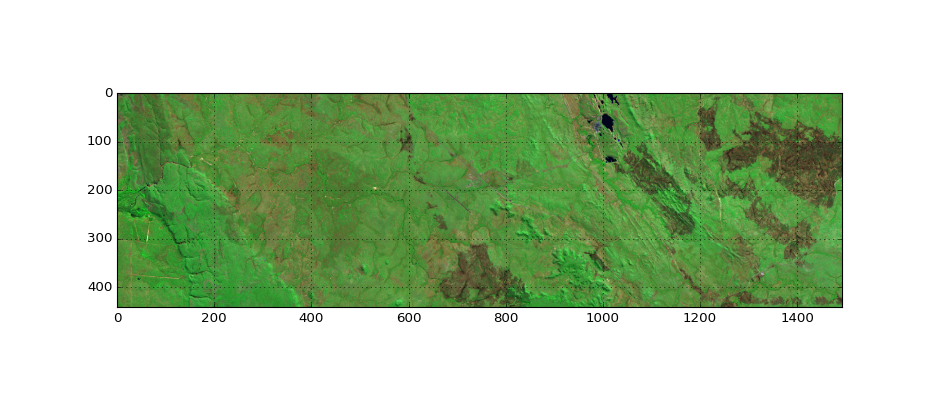

In [30]:
#Click on this image to chose the location for the Hovmoller extraction
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(11.69,5))
plt.imshow(scaled)
#plt.scatter(x=[x], y=[y], c='r')

plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

In [31]:
x, y

(1337, 262)

<IPython.core.display.Javascript object>


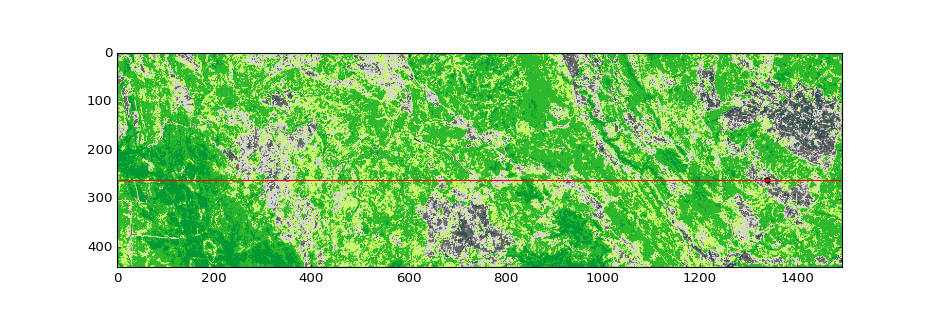

<xarray.DataArray 'time' ()>
numpy.datetime64('2016-05-22T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2016-05-22


In [33]:
fig = plt.figure(figsize=(11.69,4))

#Define coordinates of interest
timeactual = all_nbr_sorted.time[time_slice]

tss_min = 0
tss_max = 2000
plt.scatter(x=[x], y=[y], c='r')

plt.plot([0, all_nbr_sorted.shape[2]], [y,y], 'r')
#plt.plot([xdim,xdim], [0, all_ndvi_sorted.shape[1]], 'aquamarine')

ndvi_cmap = mpl.colors.ListedColormap(['blue' '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
tss_cmap = mpl.colors.ListedColormap(['navy', 'blue', 'deepskyblue','aquamarine' , 'burlywood' , 'saddlebrown'])
nbr_cmap = mpl.colors.ListedColormap(['darkslategray','dimgray' , 'lightgrey' , '#ccff66' , '#2eb82e', '#009933'])

ndvi_bounds = [-1, 0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
nbr_bounds = [-1, -0.1, 0, 0.1, 0.2, 0.4, 0.6]
tss_bounds = [0, 10, 20, 50, 80, 100, 150]

tss_norm = mpl.colors.BoundaryNorm(tss_bounds, tss_cmap.N)
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
nbr_norm = mpl.colors.BoundaryNorm(nbr_bounds, nbr_cmap.N)

#imshow(all_ndvi_sorted.isel(time = time_slice), cmap = ndvi_cmap, norm = ndvi_norm)
imshow(all_nbr_sorted.isel(time = time_slice), cmap = nbr_cmap, norm = nbr_norm)


print timeactual.astype(datetime64)

<IPython.core.display.Javascript object>


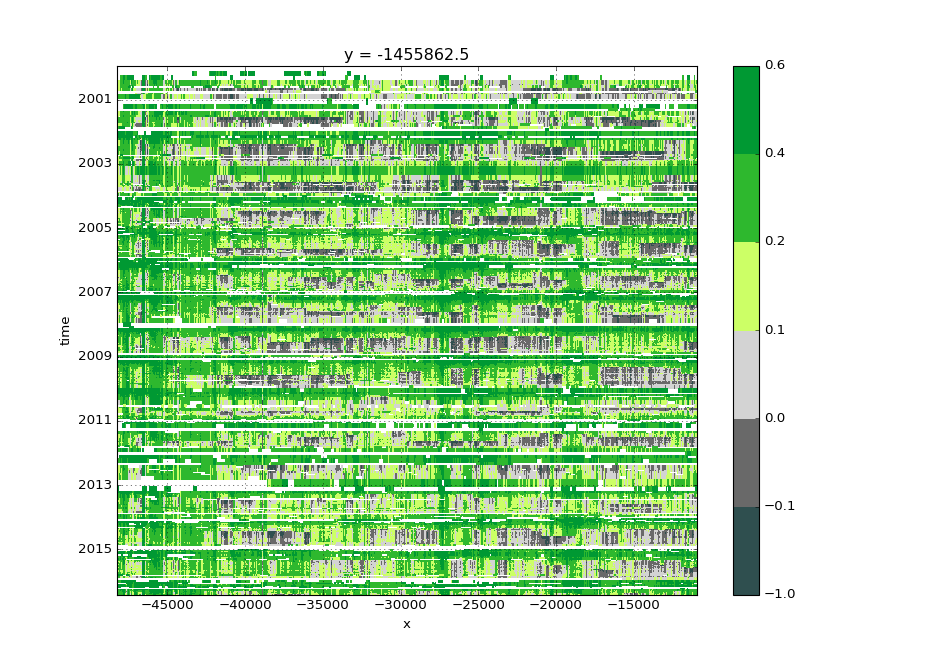

In [36]:
#Use this to select the first location from which to retrieve a time series
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global mapx, hovtime
    mapx, hovtime = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize=(11.69,8.27))


all_nbr_sorted.isel(#x=[xdim],
                     y=[y]
                     ).plot(norm= nbr_norm, cmap = nbr_cmap, yincrease = False)


plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)


In [66]:
#this converts the map x coordinate into image x coordinates
~nbar_clean.affine * (mapx, -1456812)
image_coords = ~nbar_clean.affine * (mapx, -1456812)
imagex = int(image_coords[0])
imagex
#good example at 563

437

<IPython.core.display.Javascript object>


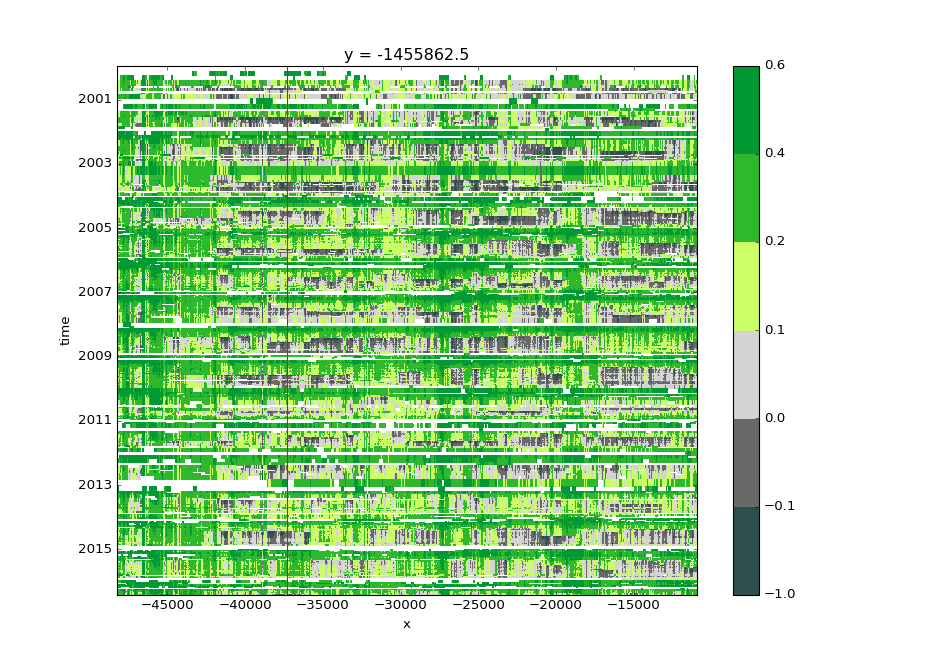

In [69]:
#This will show the location of the first time series you selected and allows 
#you to select the location of a second time series
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global mapx2, hovtime
    mapx2, hovtime = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize=(11.69,8.27))


all_nbr_sorted.isel(#x=[xdim],
                     y=[y]
                     ).plot(norm= nbr_norm, cmap = nbr_cmap, yincrease = False)

plt.plot([mapx, mapx],[start_of_epoch, end_of_epoch], 'r')

#plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

In [72]:
~nbar_clean.affine * (mapx2, -1456812)
image_coords2 = ~nbar_clean.affine * (mapx2, -1456812)
imagex2 = int(image_coords2[0])
imagex2
#good example at 1309

1374

In [73]:
#Use this to convert between map coordinates and image raster x/y coordinates
#This is an ugly cludge to get the x min and max coordinates out to specify axis coordinates for axis subsetting
sx = nbar_clean.affine * (0, -1449300.0) 
ex = nbar_clean.affine * (sensor1_nbar.swir2.shape[2], -1449300.0 )
startx = sx[0]
endx = ex[0]
print startx 
print endx

-48250.0
-10950.0


<IPython.core.display.Javascript object>


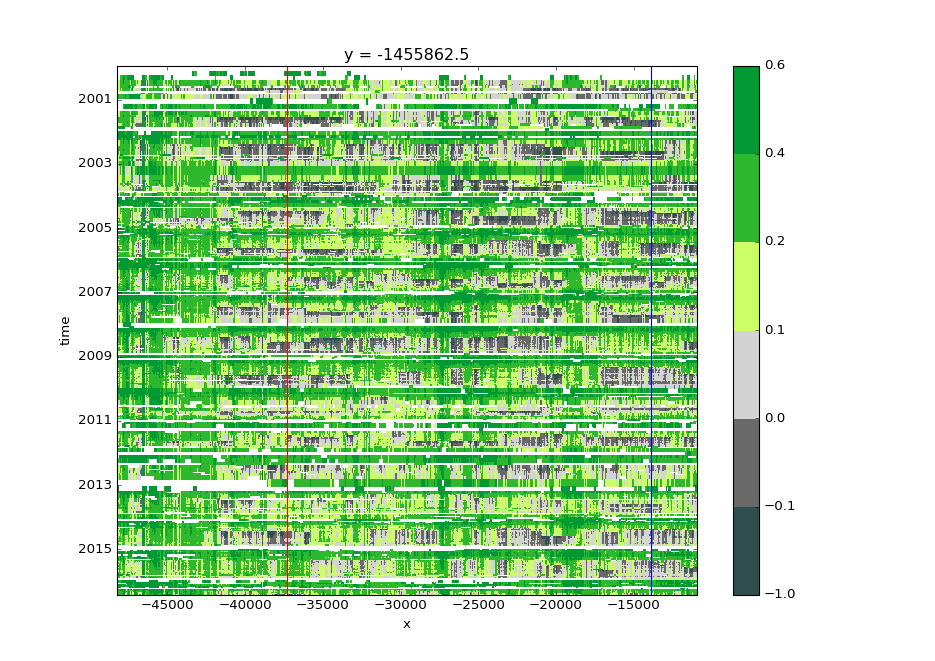

In [80]:
fig = plt.figure(figsize=(11.69,8.27))
#use firstyear and last year to focus in on a particular epoch
firstyear = '2005-01-01'
lastyear = '2005-12-31'
all_nbr_sorted.isel(#x=[xdim],
                     y=[y]
                     ).plot(norm= nbr_norm, cmap = nbr_cmap, yincrease = False)
plt.plot([mapx, mapx],[start_of_epoch, end_of_epoch], 'r')
plt.plot([mapx2, mapx2],[start_of_epoch, end_of_epoch], 'b')
#plt.axis([startx, endx, lastyear , firstyear])



In [ ]:
print mapx
print imagex
print mapx2
print imagex2

<IPython.core.display.Javascript object>


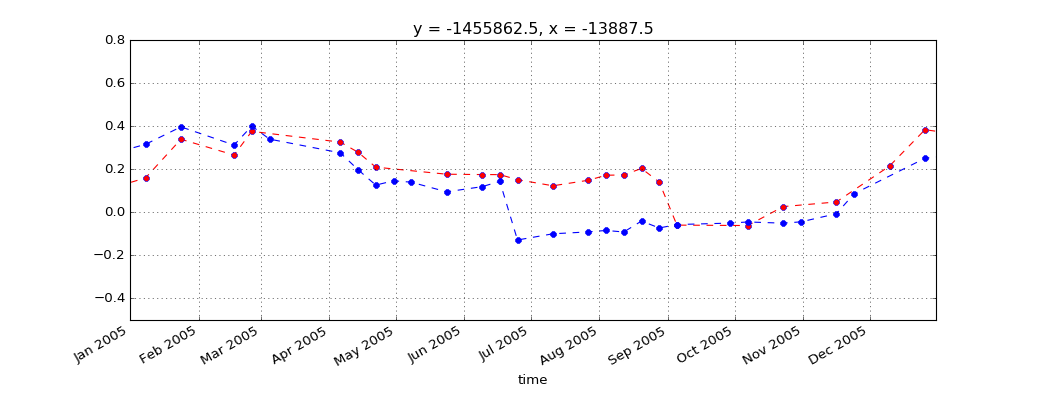

In [76]:
#Use this plot to visualise NBR time series
fig = plt.figure(figsize=(13,5))

all_nbr_sorted.isel(x=[imagex],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
all_nbr_sorted.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')
plt.axis([firstyear , lastyear ,-0.5, 0.8])
plt.grid()

In [ ]:
'''#This cell allows you to plot NDVI for terrestrial targets and TSS for aquatic targets in the same figure
fig = plt.figure(figsize=(11.69,8.27))

#water_only = all_tss_sorted.where(nbar_clean_sorted['swir1']<1000)
#water_only.isel(#x=[x],
#                     y=[y]
#                     ).plot(cmap = tss_cmap, norm = tss_norm, yincrease = False)
land_only = all_ndvi_sorted.where(nbar_clean_sorted['swir1']>1000)
land_only.isel(#x=[x],
                     y=[y]
                     ).plot(cmap = ndvi_cmap, norm = ndvi_norm, yincrease = False)'''

## Pixel drill

<IPython.core.display.Javascript object>


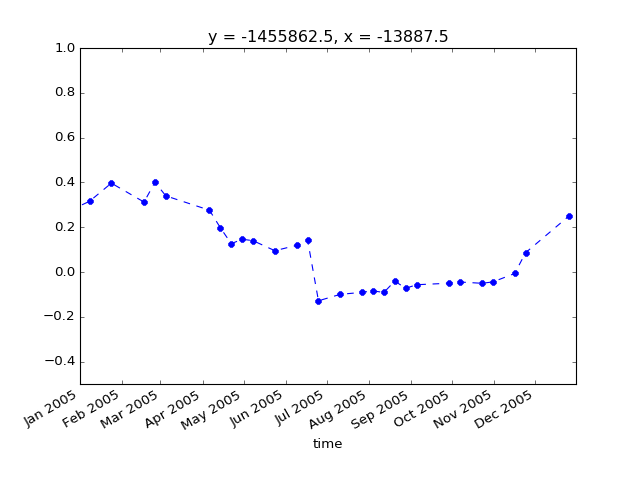

['2005-01-01', '2005-12-31', -0.5, 1]

In [95]:
#Use this plot to visualise TSS time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure()


fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

#firstyear = '2010-06-01'
#lastyear = '2015-1-30'
#all_nbr_sorted.isel(x=[imagex],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
all_nbr_sorted.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')

#water_only.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'm', marker = '8', mec = 'b', mfc ='m')
plt.axis([firstyear , lastyear ,-0.5, 1])

<IPython.core.display.Javascript object>


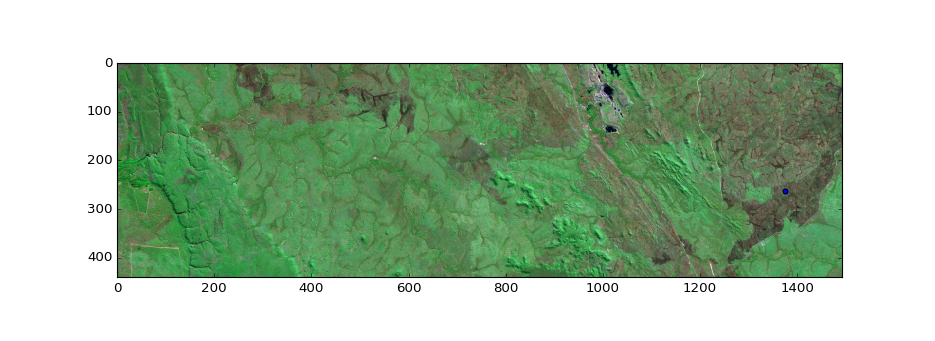

2005-06-25


In [96]:
#Select time slice of interest
time_slice = matplotlib.dates.num2date(time_int).date()

rgb2 = nbar_clean.sel(time =time_slice).to_array(dim='color').sel(color=['swir2', 'nir', 'green']).transpose('y', 'x', 'color')


fake_saturation = 6000
clipped_visible = rgb2.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize=(11.69,4.27))
print time_slice
plt.scatter(x=[imagex2], y=[y], c='b')

imshow(scaled, interpolation = 'nearest')

In [101]:
ts = all_nbr_sorted.isel(x=[imagex2],y=[y]).dropna('time', how = 'any')
#ts

<IPython.core.display.Javascript object>


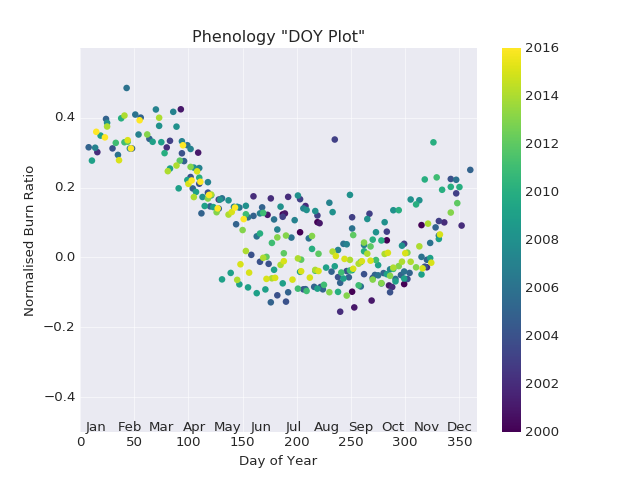

In [107]:

#This is the phenology stacking code from Chris Holden - Boston University
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots()

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.viridis, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
ax.set_ylim((-0.5, 0.6))
ax.set_xlabel('Day of Year')
ax.set_ylabel('Normalised Burn Ratio')
ax.set_title('Phenology "DOY Plot"')

In [ ]:
time_slice

In [ ]:
tdelta = scaled.time